Data preprocessing :
<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>

In [343]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]



In [344]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

eastwind  northwind  eastcurrent  northcurrent  sog    cog
0  2.267688   6.741482     0.113690      0.044994  0.0  358.9
1  1.782681   6.410275     0.113690      0.044994  0.0  358.9
2  1.154659   6.385135     0.083984      0.054000  0.0  358.9
3  0.348801   6.094659     0.083984      0.054000  0.0  358.9
4 -0.593128   6.153186     0.083984      0.054000  0.0  358.9

In [345]:
dfpre["True North Wind Direction"] = 180 +  np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))

In [346]:
dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [347]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [348]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

Unnamed: 0                Time        LON        LAT  \
0           0 2021-01-01 00:00:00  14.689663  55.098452   
1           1 2021-01-01 01:00:00  14.689659  55.098451   
2           2 2021-01-01 02:00:00  14.689648  55.098468   
3           3 2021-01-01 03:00:00  14.689646  55.098471   
4           4 2021-01-01 04:00:00  14.689644  55.098462   

   Temperature above oceans  Air density above oceans  Max wave height  \
0                277.311035                  1.259323         1.893614   
1                277.328369                  1.259985         1.752303   
2                277.390625                  1.260244         1.619775   
3                277.411377                  1.260148         1.518736   
4                277.430664                  1.260634         1.455034   

   Swell period  Wind wave period  Wave period  ...  Heading  Wind Speed  \
0      4.818881          3.818459     4.154329  ...    174.0    7.112664   
1      4.755800          3.470216     4.130580  ...    174.0    6.653538   
2      4.645083          3.259682     4.083755  ...    174.0    6.488697   
3      4.588384          3.177906     4.010502  ...    174.0    6.104632   
4      4.528841          3.281654     3.913362  ...    174.0    6.181707   

   Current Speed  True Wind Direction  True Current Direction  \
0       0.122270           155.408180              105.591753   
1       0.122270           158.458891              105.591753   
2       0.099846           163.749663              116.740448   
3       0.099846           170.724504              116.740448   
4       0.099846           179.505940              116.740448   

   True Swell Direction  True Wind Wave Direction  True Wave Direction  \
0             22.854050                 22.749664            22.610062   
1             26.122772                 19.152008            22.209274   
2             28.498383                 12.424912            20.857971   
3             29.956985                  6.725922            18.732071   
4             34.486298                  3.761627            15.731430   

   True North Wind Direction  True North Current Direction  
0                 198.591820                     68.408246  
1                 195.541109                     68.408246  
2                 190.250337                     57.259552  
3                 183.275496                     57.259552  
4                 174.494060                     57.259552  

[5 rows x 30 columns]

In [349]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [350]:
# Outlier Check
dfstats = df[df['Current Speed'] = 0.016703624 ]


In [401]:
dfstats.to_csv("currentoutlier2.csv")

In [351]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [352]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

Data Analysis before modelling 

In [353]:
df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

Temperature above oceans  Max wave height  Swell period  Wind wave period  \
8                 276.900391         1.661038      4.291309          3.667458   
9                 276.705566         1.501637      4.187211          3.145607   
10                276.309815         1.235528      4.012717          2.120399   
11                276.399902         1.204397      4.020009          2.090308   
12                277.134033         1.275907      4.095175          3.029945   

    Wave period  Sea surface temperature  \
8      3.757862               279.699585   
9      3.803910               279.820312   
10     3.819602                      NaN   
11     3.820546                      NaN   
12     3.815268               279.820312   

    Combined wind waves and swell height  Swell height  Wind wave height  \
8                               0.865413      0.323892          0.801956   
9                               0.785675      0.452440          0.578049   
10                              0.654636      0.556525          0.236435   
11                              0.638782      0.555405          0.226181   
12                              0.674081      0.598373          0.263031   

     Draught  ...     Heading  Wind Speed  Current Speed  True Wind Direction  \
8   5.017723  ...  269.900574    7.648595       0.104064            91.133175   
9   5.019207  ...  300.130435    6.700397       0.104050            68.884377   
10  5.019664  ...  230.117302    4.089472       0.092759           129.989203   
11  5.019009  ...  178.653615    3.821501       0.093128           170.879672   
12  5.020452  ...  125.446296    5.479353       0.086621           102.327505   

    True Current Direction  True Swell Direction  True Wind Wave Direction  \
8               143.029898             82.454986                 91.138748   
9                96.351303            134.548587                115.015200   
10              174.697284             59.296837                 47.905998   
11              107.951765              8.221531                 10.314571   
12               72.665715             47.977150                 68.470208   

    True Wave Direction  True North Wind Direction  \
8             90.495209                 181.033749   
9            120.971331                 189.014812   
10            52.498604                 180.106505   
11             1.236454                 187.773943   
12            54.270195                 203.118792   

    True North Current Direction  
8                      52.930471  
9                      36.481737  
10                     44.814586  
11                     70.701850  
12                     52.780582  

[5 rows x 22 columns]

In [354]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [355]:
# Scaling script if necessary

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_ship2 = pd.DataFrame(scaler.fit_transform(df_ship2),columns=df_ship2.columns)


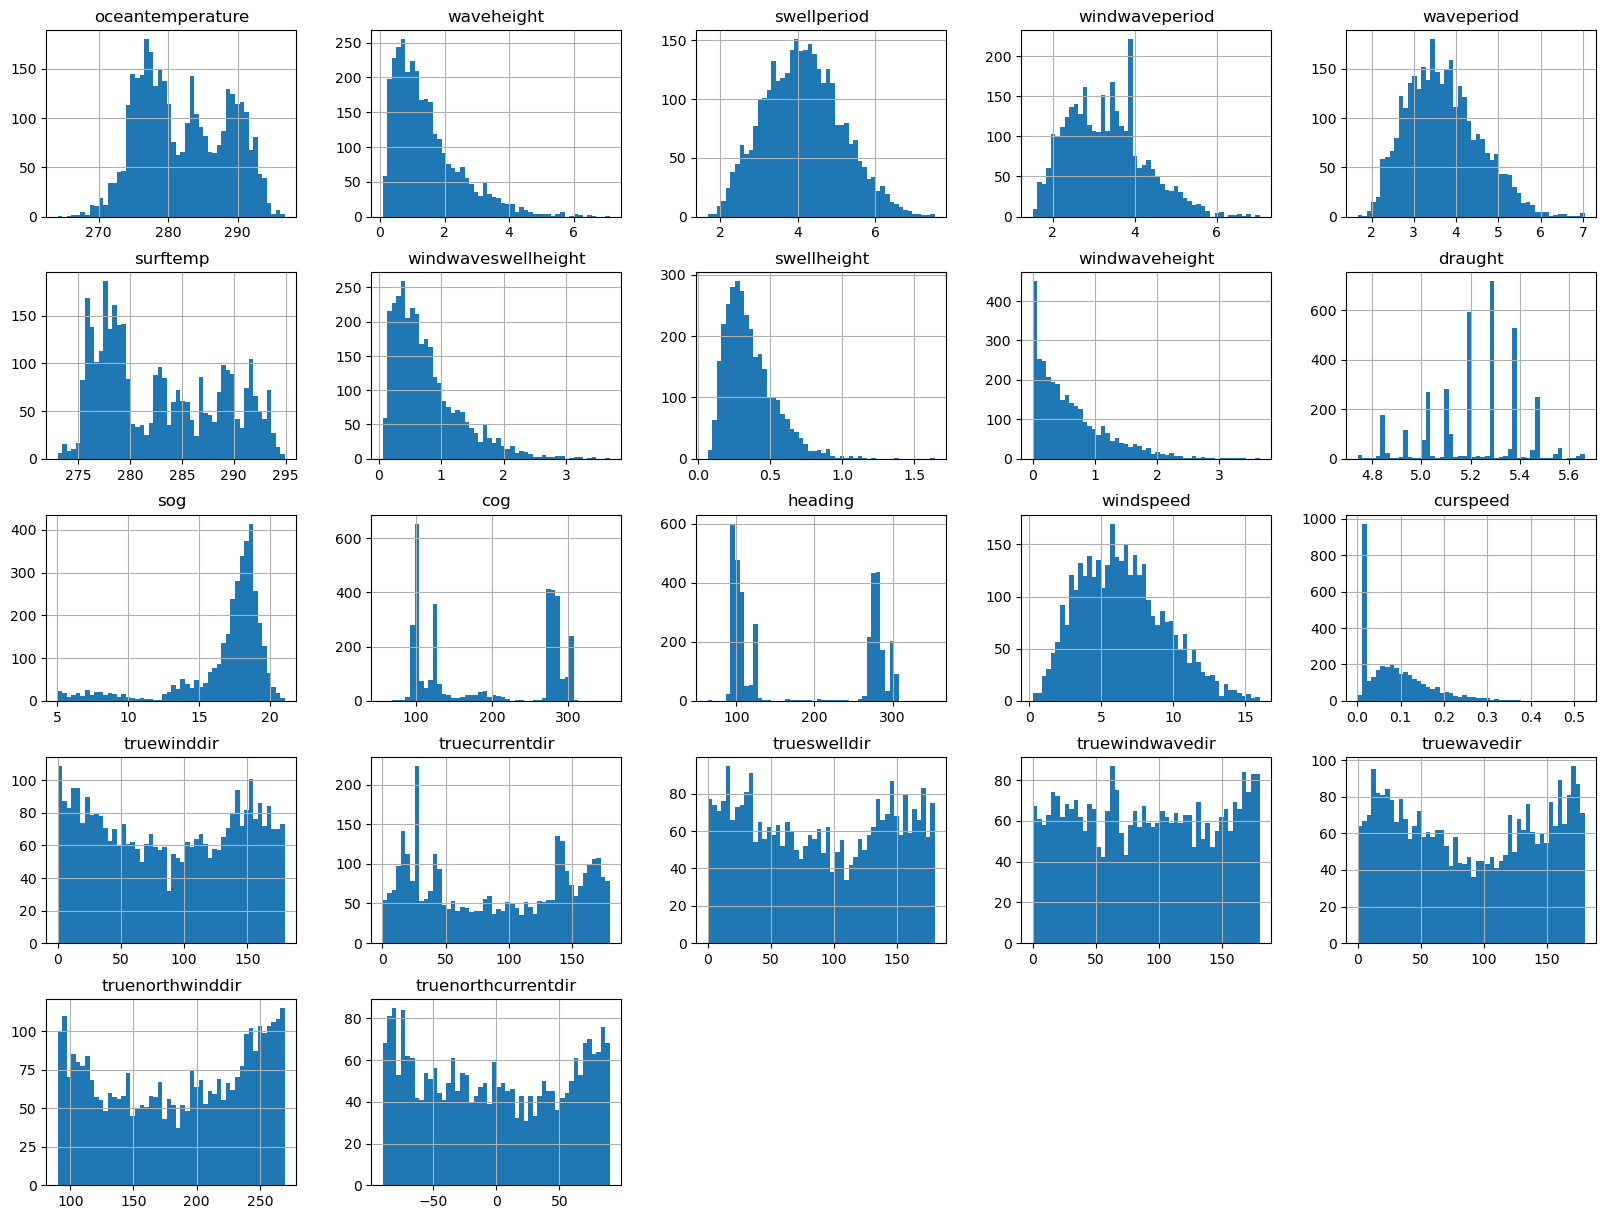

In [356]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_ship2.hist(bins=50,figsize=(20,15))
plt.show()

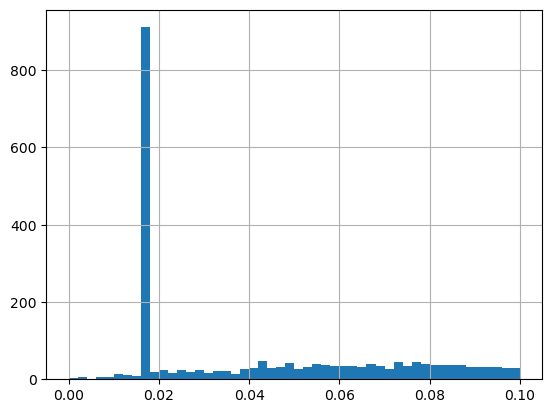

In [357]:
df_ship2['curspeed'].hist(bins=50,range=[0,0.1])
plt.show()

In [358]:
stats = df_ship2.groupby('curspeed').count()


In [359]:
stats2 = df_ship2['curspeed'].value_counts()
stats3 = df_ship2['truecurrentdir'].value_counts()
stats4 = df_ship2['windwaveheight'].value_counts()

In [360]:
hhstats = df_ship2.describe()
print(hhstats)

       oceantemperature   waveheight  swellperiod  windwaveperiod  \
count       3506.000000  3152.000000  3152.000000     3152.000000   
mean         282.187439     1.457923     4.140942        3.299684   
std            6.345629     1.052465     0.991532        0.939149   
min          264.076782     0.083379     1.681843        1.517006   
25%          276.908691     0.671875     3.416050        2.559944   
50%          281.418823     1.180761     4.102280        3.239967   
75%          288.072144     1.928374     4.810565        3.864906   
max          296.830322     7.120887     7.531564        7.052921   

        waveperiod     surftemp  windwaveswellheight  swellheight  \
count  3152.000000  3391.000000          3152.000000  3152.000000   
mean      3.698114   283.014106             0.766249     0.359745   
std       0.862321     5.765232             0.538023     0.175846   
min       1.672565   273.048584             0.065236     0.065332   
25%       3.049094   277.872803  

Feature Selection

In [361]:
corr_matrix = df_ship2.corr()
print(corr_matrix["sog"])

oceantemperature       0.066226
waveheight            -0.004305
swellperiod           -0.001119
windwaveperiod        -0.013876
waveperiod             0.002105
surftemp               0.031413
windwaveswellheight   -0.003199
swellheight           -0.020481
windwaveheight        -0.000675
draught                0.148754
sog                    1.000000
cog                    0.016333
heading                0.213539
windspeed              0.117765
curspeed               0.139609
truewinddir            0.063382
truecurrentdir         0.147950
trueswelldir           0.001415
truewindwavedir       -0.003321
truewavedir           -0.006828
truenorthwinddir       0.011171
truenorthcurrentdir    0.005945
Name: sog, dtype: float64


In [362]:
dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
dfship_corr.head()

waveheight  swellperiod  windwaveperiod  waveperiod  windwaveswellheight  \
8     1.661038     4.291309        3.667458    3.757862             0.865413   
9     1.501637     4.187211        3.145607    3.803910             0.785675   
10    1.235528     4.012717        2.120399    3.819602             0.654636   
11    1.204397     4.020009        2.090308    3.820546             0.638782   
12    1.275907     4.095175        3.029945    3.815268             0.674081   

    swellheight  windwaveheight   draught        sog         cog     heading  \
8      0.323892        0.801956  5.017723  14.578394  299.573513  269.900574   
9      0.452440        0.578049  5.019207  18.148696  302.274508  300.130435   
10     0.556525        0.236435  5.019664   9.686510  163.922318  230.117302   
11     0.555405        0.226181  5.019009  11.252112  117.003285  178.653615   
12     0.598373        0.263031  5.020452  18.119627  125.829385  125.446296   

    windspeed  curspeed  
8    7.648595  0.104064  
9    6.700397  0.104050  
10   4.089472  0.092759  
11   3.821501  0.093128  
12   5.479353  0.086621

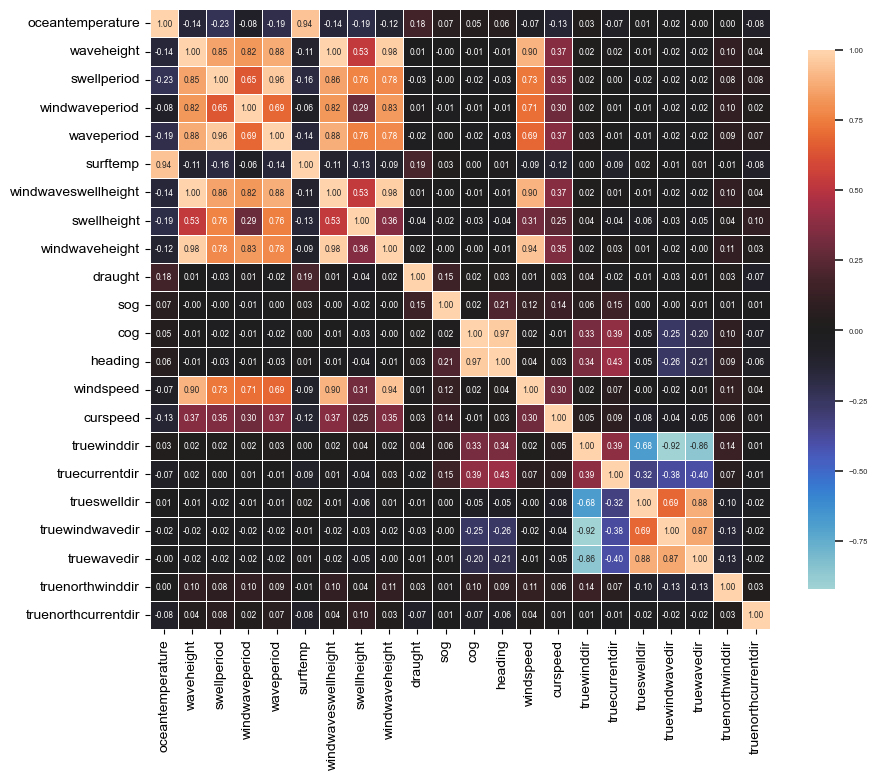

In [363]:
def correlation_heatmap(df,fontsize):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df_ship2,0.5)

Scientific Justification of HCF:

According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well 

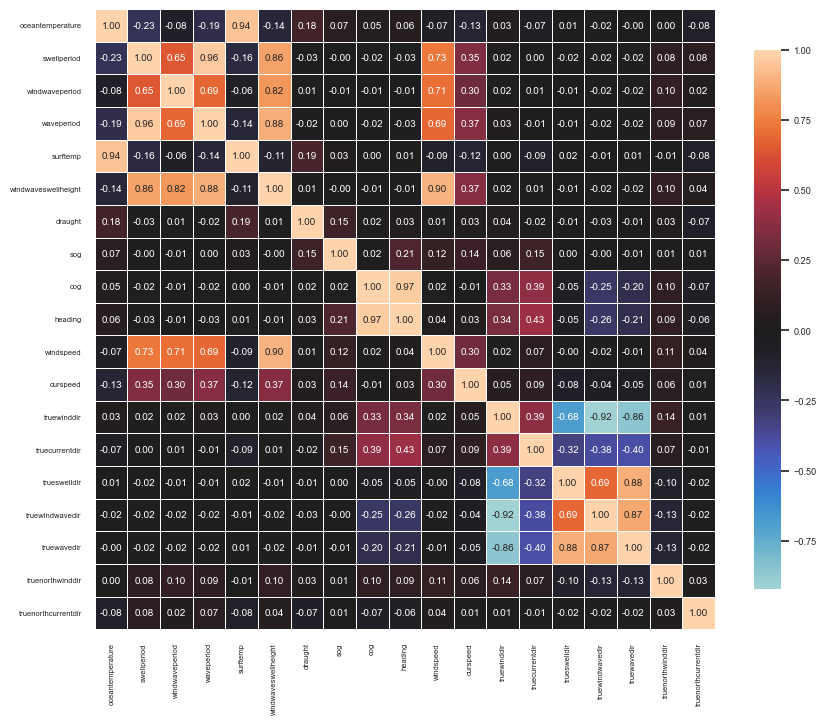

In [364]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight'],axis=1)

correlation_heatmap(df_ship2,.6)

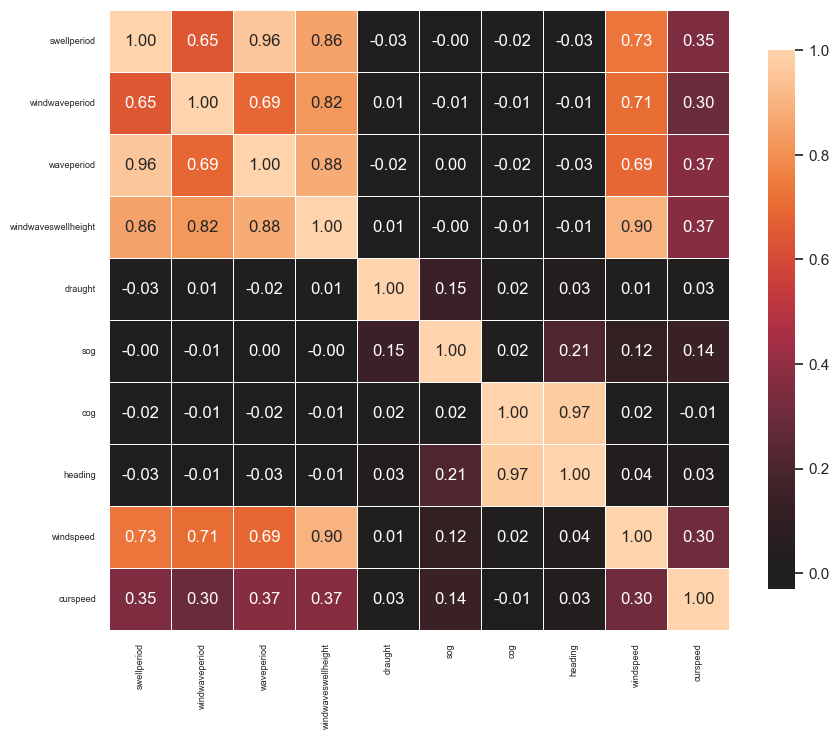

In [365]:
dfship_corrftf = dfship_corr.drop(['waveheight','swellheight','windwaveheight'],axis=1)

correlation_heatmap(dfship_corrftf,1)

In [366]:
from pandas.plotting import scatter_matrix

# attributes = df_ship2.columns

scatter_matrix(dfship_corrftf,figsize=(25,25))

array([[<AxesSubplot: xlabel='swellperiod', ylabel='swellperiod'>,
        <AxesSubplot: xlabel='windwaveperiod', ylabel='swellperiod'>,
        <AxesSubplot: xlabel='waveperiod', ylabel='swellperiod'>,
        <AxesSubplot: xlabel='windwaveswellheight', ylabel='swellperiod'>,
        <AxesSubplot: xlabel='draught', ylabel='swellperiod'>,
        <AxesSubplot: xlabel='sog', ylabel='swellperiod'>,
        <AxesSubplot: xlabel='cog', ylabel='swellperiod'>,
        <AxesSubplot: xlabel='heading', ylabel='swellperiod'>,
        <AxesSubplot: xlabel='windspeed', ylabel='swellperiod'>,
        <AxesSubplot: xlabel='curspeed', ylabel='swellperiod'>],
       [<AxesSubplot: xlabel='swellperiod', ylabel='windwaveperiod'>,
        <AxesSubplot: xlabel='windwaveperiod', ylabel='windwaveperiod'>,
        <AxesSubplot: xlabel='waveperiod', ylabel='windwaveperiod'>,
        <AxesSubplot: xlabel='windwaveswellheight', ylabel='windwaveperiod'>,
        <AxesSubplot: xlabel='draught', ylabel='windwavepe

Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [367]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [368]:
X = imputer.transform(df_ship2)

In [369]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [370]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   swellperiod          3506 non-null   float64
 2   windwaveperiod       3506 non-null   float64
 3   waveperiod           3506 non-null   float64
 4   surftemp             3506 non-null   float64
 5   windwaveswellheight  3506 non-null   float64
 6   draught              3506 non-null   float64
 7   sog                  3506 non-null   float64
 8   cog                  3506 non-null   float64
 9   heading              3506 non-null   float64
 10  windspeed            3506 non-null   float64
 11  curspeed             3506 non-null   float64
 12  truewinddir          3506 non-null   float64
 13  truecurrentdir       3506 non-null   float64
 14  trueswelldir         3506 non-null   float64
 15  truewindwavedir      3506 non-null   f

Data Split for training and test data

In [371]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 

x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog','truenorthcurrentdir','truenorthwinddir']
                                                                 ,axis=1)
                                                                ,df_ship2tr.sog,test_size=0.2,random_state=42)


In [372]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2804


In [373]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 702


Modelling using Random Forest Regressor 

In [374]:
from sklearn.ensemble import RandomForestRegressor
model_rfr = RandomForestRegressor()
model_rfr.fit(x_train,y_train)

RandomForestRegressor()

Modelling using Decision Tree Regressor

In [375]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train,y_train)

DecisionTreeRegressor()

Modelling using Multiple Linear Regression

In [376]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
model_mlr.fit(x_train,y_train)

LinearRegression()

Model Evaluation

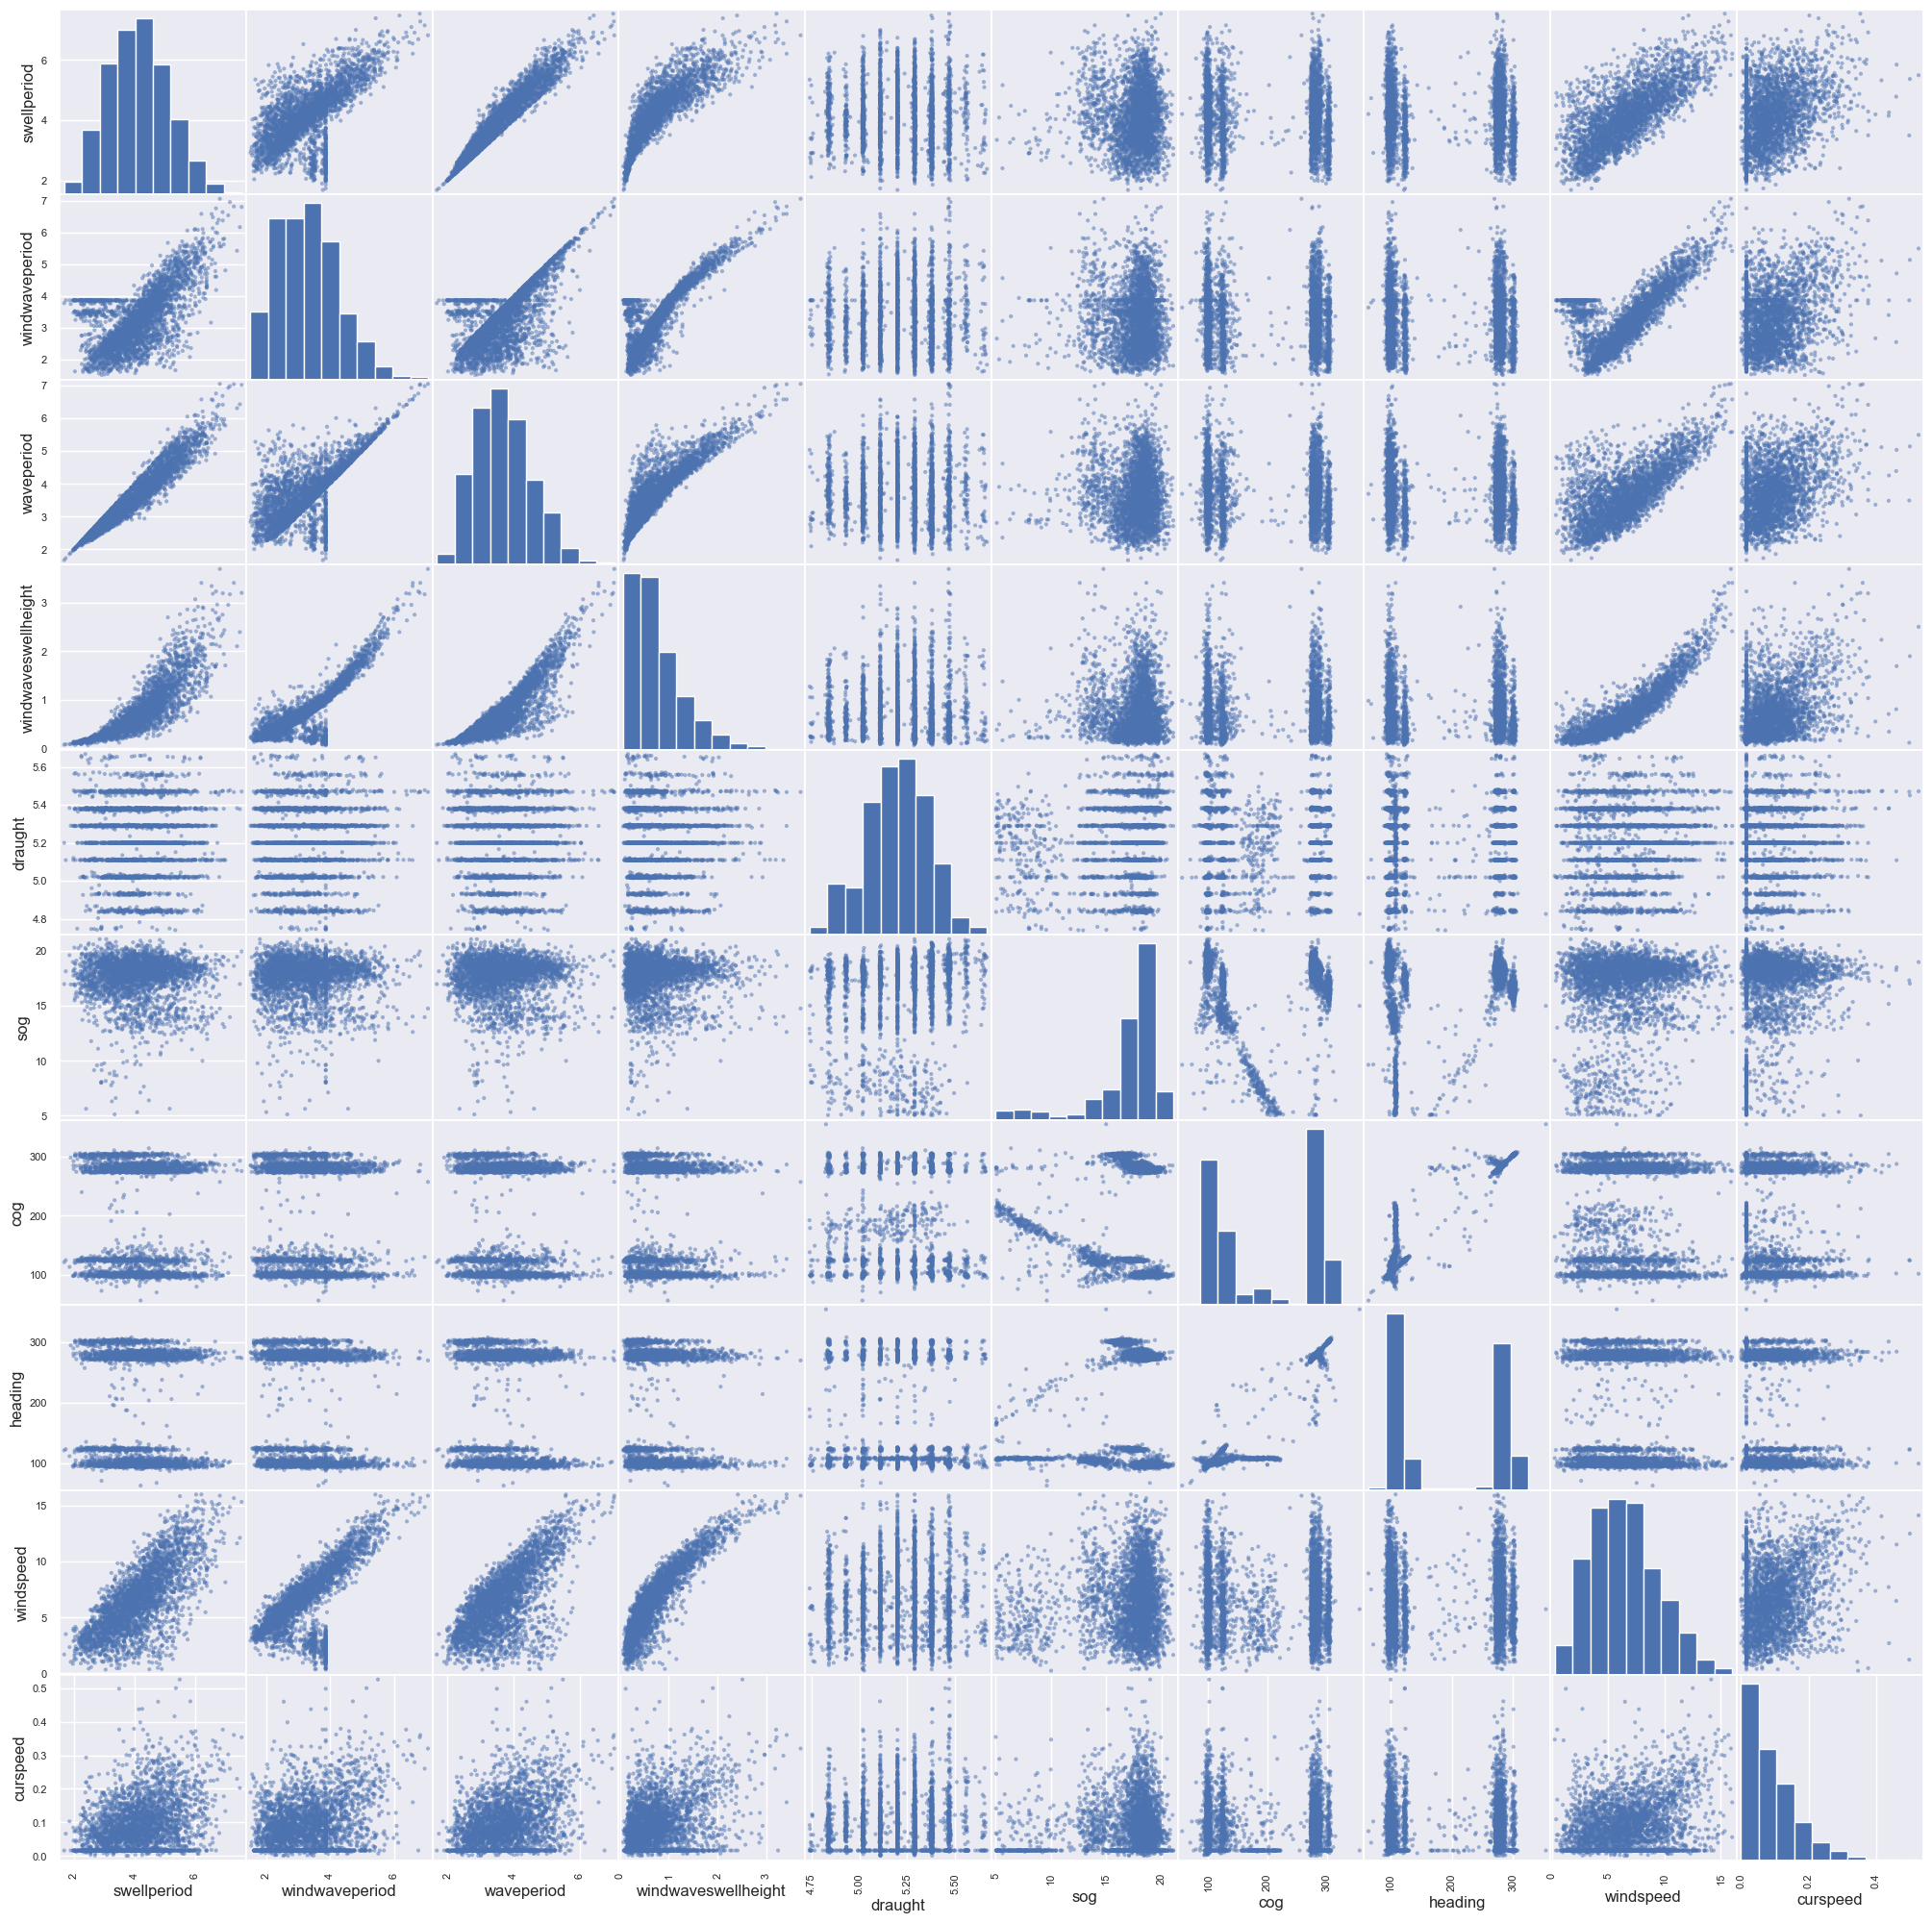

In [377]:
from sklearn import tree

def tree_visualization(width,height,model_type):
    fn=x_train.columns
    fig, axes = plt.subplots(figsize = (width,height), dpi=800)
    tree.plot_tree(model_type.estimators_[0],
               max_depth=3,
               fontsize=8,
               feature_names = fn);
    plt.show()
    #fig.savefig('rf_individualtree.png')

tree_visualization(25,5,model_rfr)

In [378]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp)

model_importance(model_rfr)

                     Importance
oceantemperature       0.004917
swellperiod            0.003877
windwaveperiod         0.006370
waveperiod             0.003846
surftemp               0.005434
windwaveswellheight    0.003595
draught                0.021973
cog                    0.479606
heading                0.435233
windspeed              0.004111
curspeed               0.007964
truewinddir            0.003715
truecurrentdir         0.006342
trueswelldir           0.005512
truewindwavedir        0.003598
truewavedir            0.003906


Evaluation of RFR

In [379]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    y_predicted = model_type.predict(x_test)
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_predicted = predict_y(x_test,model_rfr)
display_scores(x_test,y_test,model_rfr)


R^2 score (Indicate model fit. Best Score = 1): 0.932230971572797
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9323130885858057
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5544576066231905
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.715749574253752
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.38988523309999934


Evaluation of DTR

In [380]:
y_predicted = predict_y(x_test,model_dtr)
display_scores(x_test,y_test,model_dtr)

R^2 score (Indicate model fit. Best Score = 1): 0.8586690251505905
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8587236456845433
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8106967101282053
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.4926816486087782
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.5531852050000001


Evaluation of MLR 

In [381]:
y_predicted = predict_y(x_test,model_mlr)
display_scores(x_test,y_test,model_mlr)

R^2 score (Indicate model fit. Best Score = 1): 0.6925738151016398
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.6928551183965752
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.1408383126171484
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 3.246913318106988
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.9023857305284064


In [382]:
cdf = pd.DataFrame(model_mlr.coef_, x_test.columns, columns=['Coefficients'])
print(cdf)

                     Coefficients
oceantemperature         0.057269
swellperiod             -0.053912
windwaveperiod          -0.046878
waveperiod               0.545192
surftemp                -0.062714
windwaveswellheight     -0.934384
draught                  2.068219
cog                     -0.115718
heading                  0.116198
windspeed                0.091539
curspeed                -0.276481
truewinddir              0.001479
truecurrentdir          -0.000222
trueswelldir             0.002006
truewindwavedir          0.004207
truewavedir             -0.003496


Saving model to local directory

In [383]:
# Saving the model to local directory

# filename = 'savemodel_rfr.sav'
# joblib.dump(model_rfr,filename)

# filename = 'savemodel_dtr.sav'
# joblib.dump(model_dtr,filename)

Forecasting for June 2021

In [384]:
# dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)
# dfdate6.head(n=5)

In [385]:
# dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
#                            }, axis=1) 

In [386]:
# import numpy as np
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=50)

In [387]:
# imputer.fit(dfdate6)

In [388]:
# xdate = imputer.transform(dfdate6)

In [389]:
# dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [390]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

In [391]:
# y_predicted = predict_y(x_date,model_rfr)
# display_scores(x_date,y_date,model_rfr)


In [392]:
# display_scores(x_date,y_date,model_dtr)


In [393]:
# ydate_pred = y_predicted
# dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
# dfprog_sog["sog_pred"] = ydate_pred
# dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
# dfprog_sog["truenorthwinddir"] = dfdate6tr["truenorthwinddir"]

# print(dfprog_sog)

In [394]:
# dfprog = pd.concat([x_date,dfprog_sog],axis=1)
# dfprog.head(n=10)

In [395]:
# dfprog["vgms"] = dfprog["sog_pred"]/1.9438

In [396]:
# rad_gamma = np.deg2rad(dfprog["gamma"])
# rad_cog = np.deg2rad(dfprog["cog"])

In [397]:
# dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
# dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
# dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

In [398]:
# dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
# dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
# dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

In [399]:
# dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
# dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438
# dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
#                       'vgy','vcy','stw_y',
#                       'vwms_p'],axis=1)
# #df_ship.head(n=5)
# dfprog.head(n=10)

In [400]:
# dfprog.describe()